In [1]:
from my_model import *
from my_data import *
from my_plot import *
from sklearn.metrics import explained_variance_score, r2_score

In [2]:
# 1. Set a global seed.
SEED = 1234  

# 2. OS Level: Guaranteeing that Python hashes are also reproducible  
os.environ['PYTHONHASHSEED'] = str(SEED)  

# 3. Make the underlying ops of TF use deterministic implementations as much as possible (2.x). 
os.environ['TF_DETERMINISTIC_OPS']    = '1'  
os.environ['TF_CUDNN_DETERMINISM']    = '1'  

# 4. Python comes with random built-in.
random.seed(SEED)  
# 5. NumPy  
np.random.seed(SEED)  
# 6. TensorFlow  
tf.random.set_seed(SEED) 

In [3]:
#Read data
data = prepare_training_data("Berlin/berlin_extracted_train",
network_pattern_mid="network_berlin", ls_pattern_mid=".linkstats_berlin")  
data_val = prepare_training_data("Berlin/berlin_extracted_val",
network_pattern_mid="network_berlin", ls_pattern_mid=".linkstats_berlin")  

#Data Normalization
info = get_data_info(data)
data_nor =  min_max_nor_data(data,info)
data_val_nor = min_max_nor_data(data_val,info)
ds_nor = build_dataset(data_nor)
ds_val_nor = build_dataset(data_val_nor)
train_dataset_nor = ds_nor
batch_size = 32
train_ds_batched_nor = train_dataset_nor.shuffle(buffer_size=3,seed=SEED).batch(batch_size=batch_size).repeat()

In [4]:
#load model
# Load using low-level interfaces
loaded = tf.saved_model.load("Berlin/my_saved_model_berlin")  
model_input_graph_spec, label_spec = train_dataset_nor.element_spec
del label_spec  # Delete unused tag specifications
model_load = build_regression_model(
    graph_tensor_spec=model_input_graph_spec,
    node_dim=128,
    edge_dim=32,
    message_dim=128,
    next_state_dim=128,
    output_dim=25,  
    num_message_passing=3,
    l2_regularization=5e-5,
    dropout_rate=0.01, )
model_load.set_weights(loaded.variables)


f =  KerasTensor(type_spec=TensorSpec(shape=(27664, 33), dtype=tf.float32, name=None), name='tf.concat/concat:0', description="created by layer 'tf.concat'")


CPU time for 10 predictions = 1.9200184000073932 s.


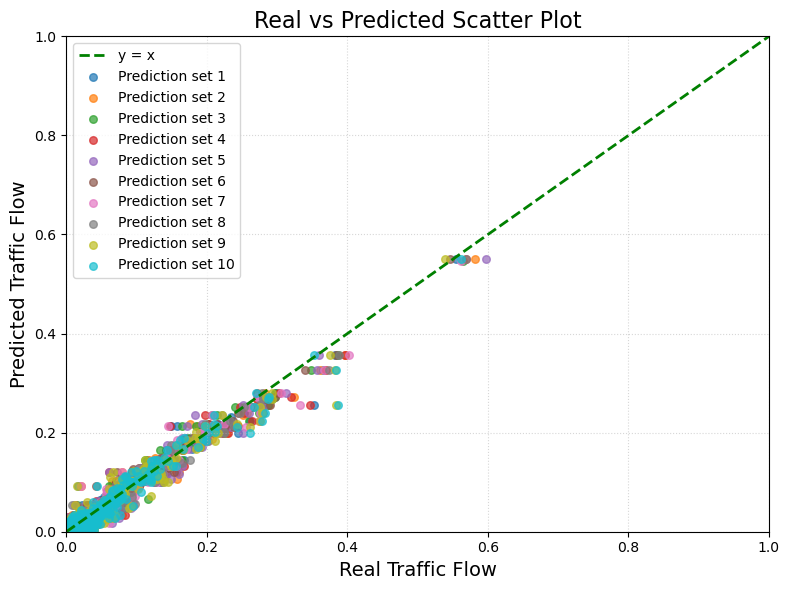

In [8]:
predict_graphs_nor = []
actual_labels_nor = []
val_ds_nor = ds_val_nor.take(10)
cpu_time = 0
# Generate prediction
for graph, labels in val_ds_nor:
    t1 = time.perf_counter()
    predict_graph = model_load(graph)  # Prediction
    t2 = time.perf_counter()
    cpu_time +=  (t2-t1)
    predict_graphs_nor.append(predict_graph.numpy())  # Save prediction results
    actual_labels_nor.append([labels.numpy()])  # Save actual labels
print(f'CPU time for 10 predictions = {cpu_time} s.')
# Convert to NumPy array
predict_graphs_nor = np.concatenate(predict_graphs_nor, axis=0)
actual_labels_nor = np.concatenate(actual_labels_nor, axis=0)

plot_real_vs_pred_subsample(y_pred=predict_graphs_nor,y_real=actual_labels_nor,n_samples=300)

In [9]:
predict_graphs_nor = []
actual_labels_nor = []
val_ds_nor = ds_val_nor
cpu_time = 0
# Generate prediction
for graph, labels in val_ds_nor:
    t1 = time.perf_counter()
    predict_graph = model_load(graph)  # Prediction
    t2 = time.perf_counter()
    cpu_time +=  (t2-t1)
    predict_graphs_nor.append(predict_graph.numpy())  # Save prediction results
    actual_labels_nor.append([labels.numpy()])  # Save actual labels
print(f'CPU time for {len(data_val)} predictions = {cpu_time} s.')
# Convert to NumPy array
predict_graphs_nor = np.concatenate(predict_graphs_nor, axis=0)
actual_labels_nor = np.concatenate(actual_labels_nor, axis=0)

CPU time for 60 predictions = 12.032503999995242 s.


MAPE = 55.437%
SMAPE = 156.575%
Median APE = 39.973%
WAPE = 40.251%


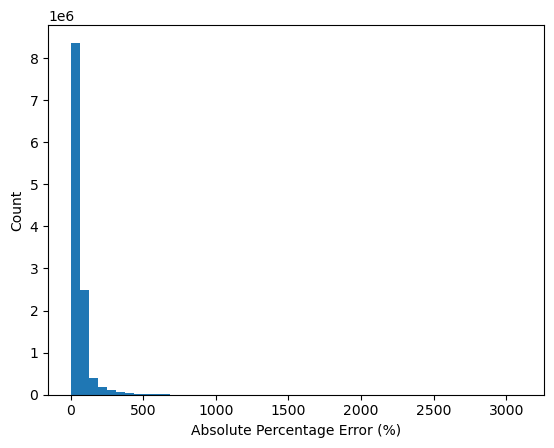

In [10]:
y_true = np.asarray(actual_labels_nor).ravel()  
y_pred = np.asarray(predict_graphs_nor).ravel()
eps = 1e-8
mask = y_true != 0  
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
print(f"MAPE = {mape:.3f}%")  
smape = 2 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6)) * 100  
print(f"SMAPE = {smape:.3f}%")
ape = np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100    
median_ape = np.median(ape)  
print(f"Median APE = {median_ape:.3f}%")
wape = np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(y_true)) * 100  
print(f"WAPE = {wape:.3f}%")

plt.hist(ape, bins=50)  
plt.xlabel("Absolute Percentage Error (%)")  
plt.ylabel("Count")  
plt.show() 


In [11]:
num = np.linalg.norm(y_true - y_pred, ord=2)  
den = np.linalg.norm(y_true,        ord=2)  
accuracy_l2 = 1 - num/(den + eps )     
print(f"Relative Accuracy (L2) = {accuracy_l2:.4f}  ({accuracy_l2*100:.2f}%)")  

Relative Accuracy (L2) = 0.7905  (79.05%)


In [12]:
ev = explained_variance_score(y_true, y_pred)  
print(f"Explained Variance (sklearn) = {ev:.4f}  ({ev*100:.2f}%)")
r2 = r2_score(y_true, y_pred)  
print(f"R² on test set: {r2:.4f} ({r2*100:.2f}%)") 

Explained Variance (sklearn) = 0.9540  (95.40%)
R² on test set: 0.9540 (95.40%)


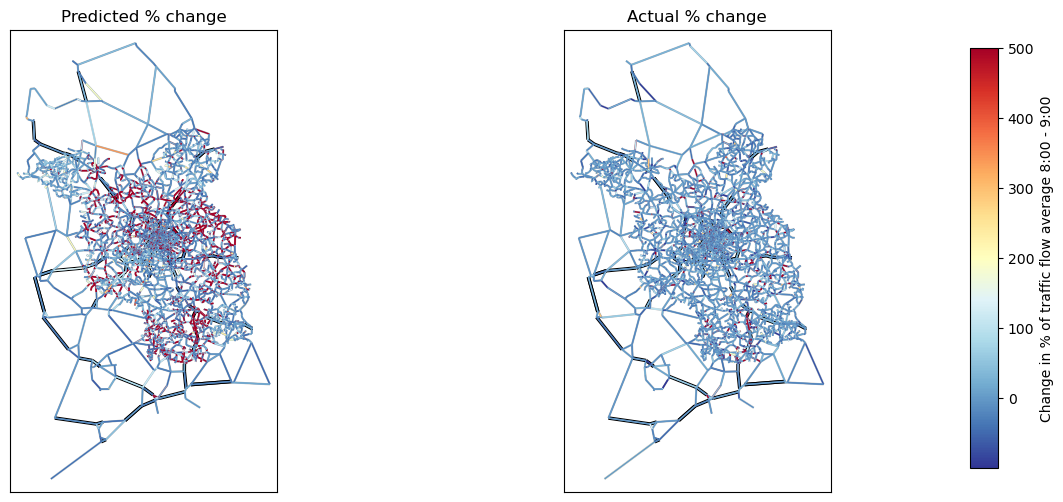

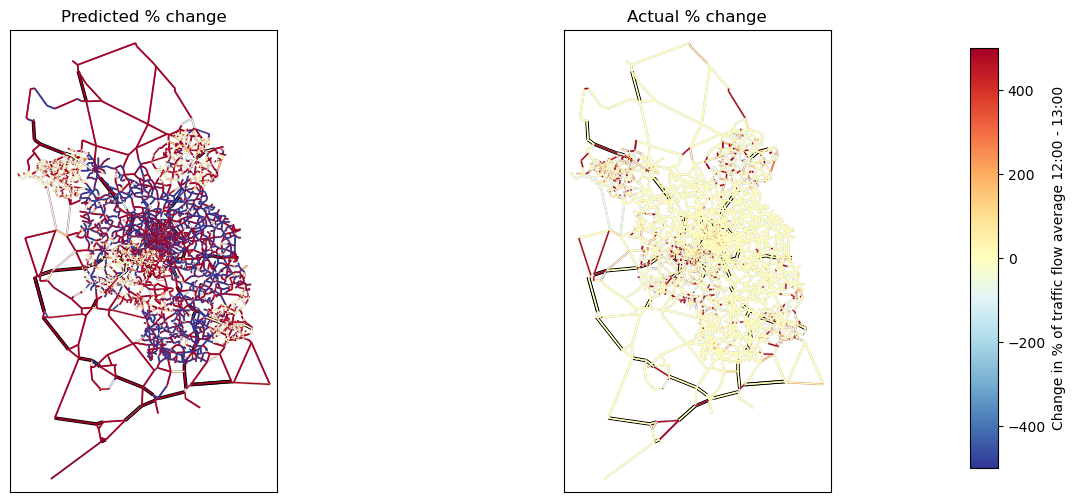

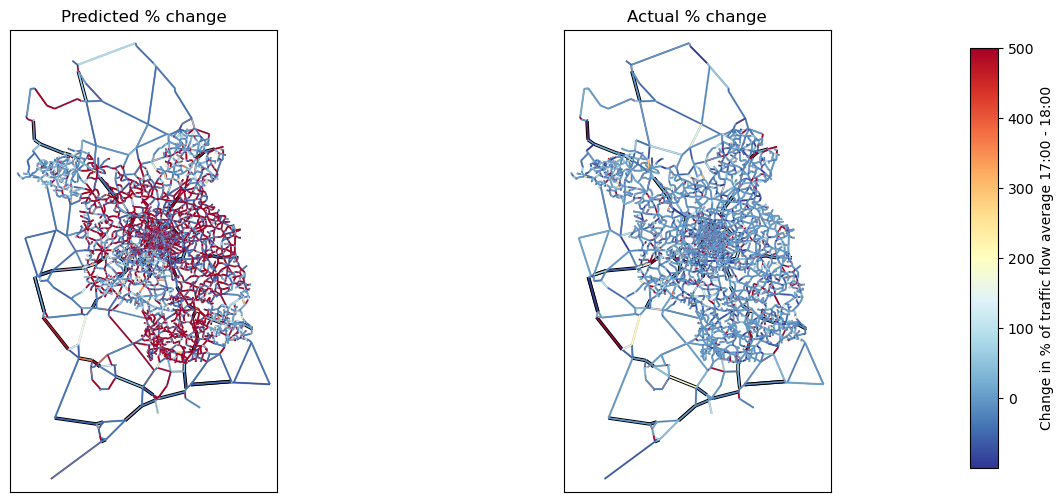

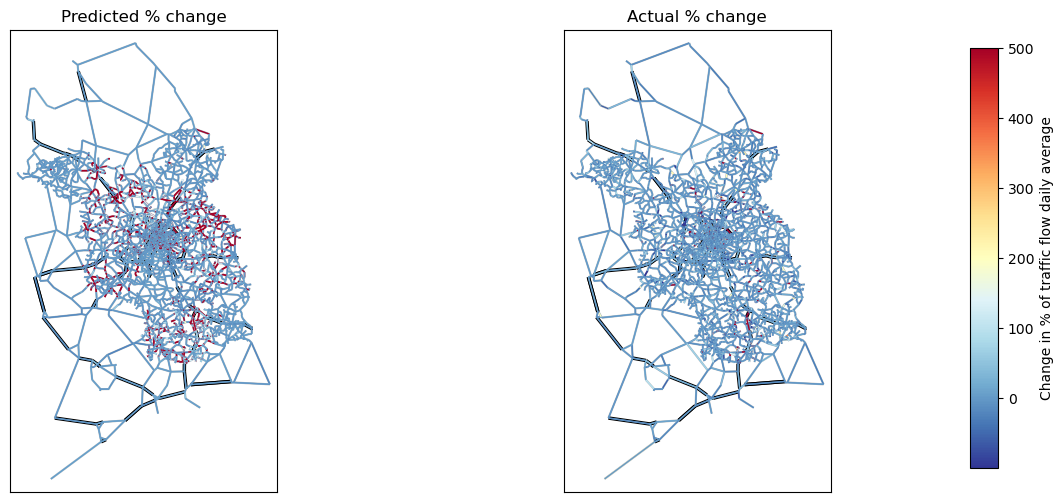

In [16]:
index_t = [8,12,17,-1]
gt = next(iter(val_ds_nor))[0]
for ti in index_t:
    c_title = f" average {ti}:00 - {ti+1}:00"
    if ti==-1 or ti==25:
        c_title = " daily average"
    #print(f"ti = {ti}")
    hsr_np = gt.node_sets['links']['base_hrs_avg'].numpy()[:,ti]
    hrs_pt = predict_graphs_nor[0][:,ti]
    hrs_lb = actual_labels_nor[0][:,ti]
    
    plot_policy_network_2panels(  
        net_xml_path="Berlin/network.xml",  
        policy_links_txt="Berlin/policy_roads_id_241.txt",  
        hrs_no_policy=hsr_np,   
        hrs_pred=hrs_pt,  
        hrs_real=hrs_lb,
        c_title=c_title 
    )  